In [1]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
# 시계열 data split
from sklearn.model_selection import TimeSeriesSplit
# timeseriessplit 시각화
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
# 모델
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')

In [2]:
# timeseriessplit 시각화용 함수
def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

In [3]:
# blocked TimeSeriesSplit 용 class 정의
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
    
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

# training 데이터 셋 만들기

## 1. gens : 실제 발전량 ( y로 쓸 예정 ) 
## 2. p_gens : 모델별 발전량 ( x변수로 추가 할 예정 )
## 3. wf : 기상 예측량 ( x변수로 추가 할 예정 )

In [4]:
gens = pd.read_csv("../gens.csv")
p_gens = pd.read_csv("../pred.csv")
wf = pd.read_csv("../weather_forecast.csv")

## 날씨 예측을 10시에 한번 17시에 한번 진행 함으로 2개로 나눠야함.

In [10]:
# 날씨 예측량을 round1,2로 분리함
wf_round1 = wf[wf["round"]==1]
wf_round2 = wf[wf["round"]==2]

## p_gens를 x변수로 만들기 위해서 모델별로 분리

In [11]:
# 발전량 예측량을 모델별로 분리해서 변수로 만들라고 분리하는거
# round1에 대해 진행할 경우에 이거 실행
p_gens0 = p_gens.loc[(p_gens["model_id"]==0) & (p_gens["round"]==1)].reset_index()
p_gens1 = p_gens.loc[(p_gens["model_id"]==1) & (p_gens["round"]==1)].reset_index()
p_gens2 = p_gens.loc[(p_gens["model_id"]==2) & (p_gens["round"]==1)].reset_index()
p_gens3 = p_gens.loc[(p_gens["model_id"]==3) & (p_gens["round"]==1)].reset_index()
p_gens4 = p_gens.loc[(p_gens["model_id"]==4) & (p_gens["round"]==1)].reset_index()


In [5]:
# 발전량 예측량을 모델별로 분리해서 변수로 만들라고 분리하는거
# round2에 대해 진행할 경우에 이거 실행
p_gens0 = p_gens.loc[(p_gens["model_id"]==0) & (p_gens["round"]==2)].reset_index()
p_gens1 = p_gens.loc[(p_gens["model_id"]==1) & (p_gens["round"]==2)].reset_index()
p_gens2 = p_gens.loc[(p_gens["model_id"]==2) & (p_gens["round"]==2)].reset_index()
p_gens3 = p_gens.loc[(p_gens["model_id"]==3) & (p_gens["round"]==2)].reset_index()
p_gens4 = p_gens.loc[(p_gens["model_id"]==4) & (p_gens["round"]==2)].reset_index()

## p_gens 변수로 만들어진 데이터 셋, wf로 만든 데이터셋을 통합해야함. 시간을 기준으로 통합 예정

In [12]:
# p_gens(모델 예측량) 데이터 프레임 생성
x_df = pd.DataFrame({"m0": p_gens0["amount"],"m1": p_gens1["amount"],
              "m2": p_gens2["amount"],"m3": p_gens3["amount"],
              "m4" : p_gens4["amount"],"time" : p_gens0["time"]})

In [13]:
# time을 기준으로 두 데이터 병합 ( p_gens, wf )
# 1차 모델링의 Y값으로 쓰일 발전량 gens도 같이 병합
# round2에 대해 수행해야하면 wf_round2/ 아니면 wf_round1
xy_df = pd.merge(x_df,wf_round1,on="time")
xy_df = pd.merge(xy_df,gens,on="time")

# 월과 날짜 변수를 추가 할 것임, 또한 시간대를 기준으로 데이터프레임을 3개 생성해야함으로 hour 변수도 추가
xy_df["time"]=pd.to_datetime(xy_df["time"])
xy_df["month"]=xy_df["time"].dt.month
xy_df["day"]=xy_df["time"].dt.day
xy_df["hour"]=xy_df["time"].dt.hour


In [14]:
# 시간에 따라 전체 통합된 데이터셋을 3개로 분리
# 7-10, 11-14 , 15-19
xy_df_1 = xy_df[(xy_df["hour"]<=10) & (xy_df["hour"]>=7)]
xy_df_2 = xy_df[(xy_df["hour"]<=15) & (xy_df["hour"]>=11)]
xy_df_3 = xy_df[(xy_df["hour"]<=19) & (xy_df["hour"]>=16)]

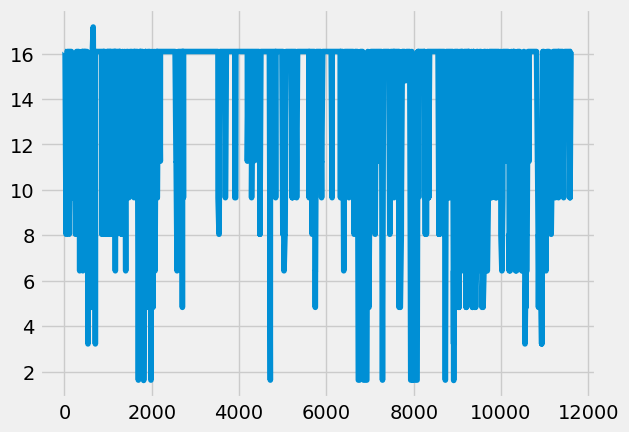

In [17]:
plt.plot(xy_df_2["vis"])

## 클러스터링 시작

### 패널 형식으로 만들어야함

In [18]:
ts_ary = xy_df_2.copy()
ts_ary["time"] = pd.to_datetime(ts_ary["time"])
ts_ary["year"] = ts_ary["time"].dt.year
ts_ary["month"] = ts_ary["time"].dt.month
ts_ary["hour"] = ts_ary["time"].dt.hour
ts_ary

,m0,m1,m2,m3,m4,time,round,cloud,temp,humidity,...,dew_point,vis,uv_idx,azimuth,elevation,amount,month,day,hour,year
10,32.4885,39.2311,45.8314,45.4765,29.1206,2022-06-19 11:00:00+09:00,1,100.0,21.51,89.0,...,18.3333,16.0934,5.0,112.342,66.4014,59.0,6,19,11,2022
11,50.9095,57.3688,54.7892,60.2924,36.7744,2022-06-19 12:00:00+09:00,1,88.0,22.34,84.0,...,18.3333,16.0934,11.0,143.612,76.3123,55.0,6,19,12,2022
12,57.6032,60.0244,51.6923,55.4945,47.5495,2022-06-19 13:00:00+09:00,1,72.0,23.17,81.0,...,17.7778,16.0934,11.0,207.104,77.4400,65.0,6,19,13,2022
13,55.9935,57.9255,53.5617,53.7681,48.5661,2022-06-19 14:00:00+09:00,1,67.0,23.89,78.0,...,18.8889,16.0934,8.0,244.082,68.3532,46.0,6,19,14,2022
14,54.2828,54.6998,53.0764,51.6307,48.7599,2022-06-19 15:00:00+09:00,1,56.0,24.34,76.0,...,18.3333,16.0934,5.0,259.989,56.6154,41.0,6,19,15,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11602,63.1783,58.6968,61.7412,62.7866,44.0468,2023-10-15 11:00:00+09:00,1,12.0,18.98,68.0,...,12.7778,16.0934,4.0,152.542,42.9224,54.0,10,15,11,2023
11603,68.6602,66.2160,69.6301,71.2110,53.3804,2023-10-15 12:00:00+09:00,1,10.0,19.20,67.0,...,12.7778,16.0934,4.0,172.860,46.6011,51.0,10,15,12,2023
11604,68.0834,68.7839,70.7959,72.0536,59.8493,2023-10-15 13:00:00+09:00,1,8.0,19.37,67.0,...,13.3333,16.0934,4.0,194.339,45.8045,82.0,10,15,13,2023
11605,61.4792,61.4023,61.7862,61.6858,58.0161,2023-10-15 14:00:00+09:00,1,10.0,19.47,68.0,...,13.3333,16.0934,3.0,213.572,40.7522,45.0,10,15,14,2023


In [19]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

In [20]:
ts_ary = ts_ary[ts_ary["month"].isin([9,10,11])]
ts_ary = ts_ary[ts_ary["hour"].isin([11,12,13,14,15])]

In [21]:
h = 0
t = 5
st_array = []
for i in range(0,136):
    st = np.array(ts_ary["amount"][h:t])
    st = st.reshape(-1,1)
    st_array.append(st)
    h+=5
    t+=5
    
res = np.stack(st_array,axis=0)



C:\Users\admin\AppData\Local\Temp\ipykernel_36944\785207643.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  st = np.array(ts_ary["amount"][h:t])


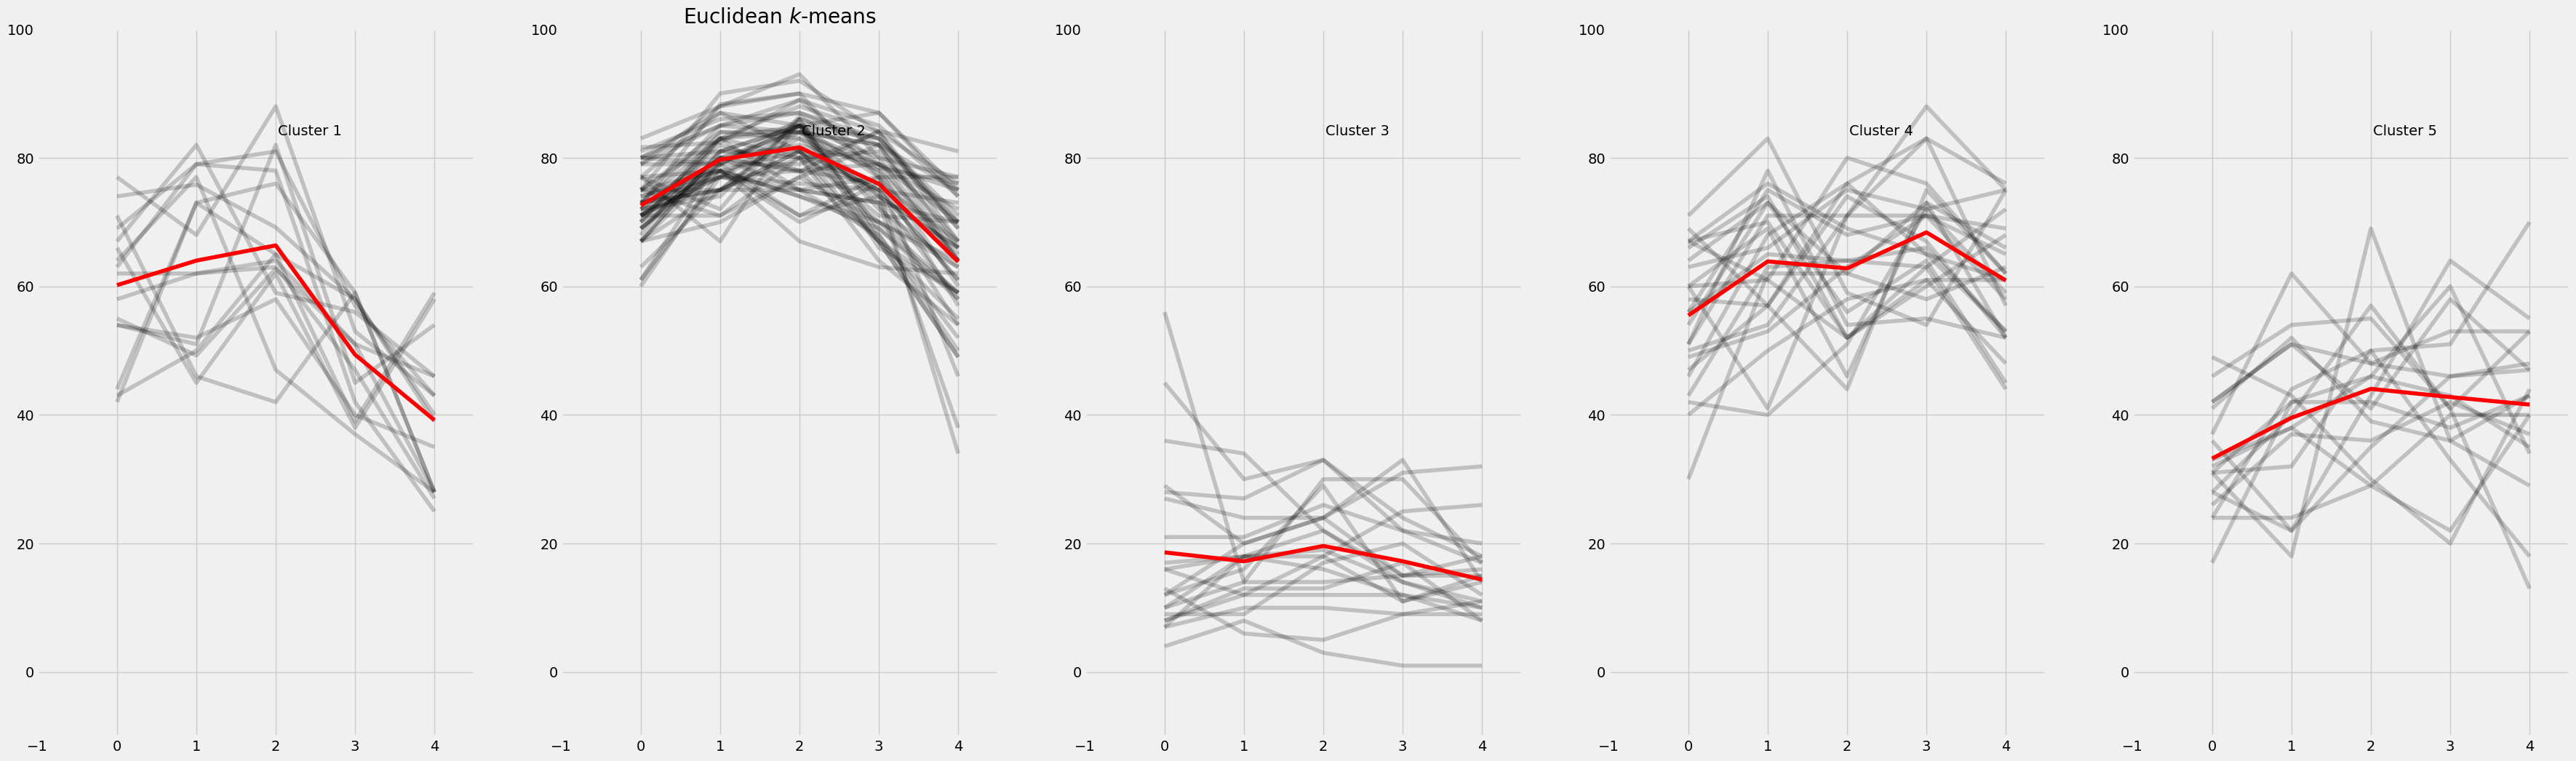

In [22]:
km = TimeSeriesKMeans(n_clusters=5, verbose=False, random_state=42, n_jobs=-1,metric="euclidean")
y_pred = km.fit_predict(res)

plt.figure(figsize=(40,12))
for yi in range(5):
    plt.subplot(1, 5, yi + 1)
    for xx in res[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(-1, 4.5)
    plt.ylim(-10, 100)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

### 클러스터 열 추가

In [23]:
idx_list = np.repeat(y_pred,5)
ts_ary["cluster"] = idx_list

In [24]:
ts_ary

,m0,m1,m2,m3,m4,time,round,cloud,temp,humidity,...,vis,uv_idx,azimuth,elevation,amount,month,day,hour,year,cluster
1786,57.0944,58.4438,55.4405,59.8641,45.5105,2022-09-01 11:00:00+09:00,1,100.0,24.32,74.0,...,16.0934,7.0,135.254,55.8898,36.0,9,1,11,2022,2
1787,63.4958,76.4396,73.8421,68.4183,42.6518,2022-09-01 12:00:00+09:00,1,100.0,25.02,71.0,...,16.0934,8.0,161.559,62.4236,34.0,9,1,12,2022,2
1788,62.8084,75.3559,70.6448,68.5010,54.7344,2022-09-01 13:00:00+09:00,1,100.0,25.58,70.0,...,16.0934,6.0,194.207,62.8751,22.0,9,1,13,2022,2
1789,59.8069,74.0392,70.3801,68.7556,36.9778,2022-09-01 14:00:00+09:00,1,100.0,25.96,68.0,...,16.0934,5.0,221.728,56.9884,15.0,9,1,14,2022,2
1790,56.9254,64.4406,67.5103,61.0753,24.9365,2022-09-01 15:00:00+09:00,1,99.0,25.97,70.0,...,16.0934,4.0,240.326,47.3516,18.0,9,1,15,2022,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11602,63.1783,58.6968,61.7412,62.7866,44.0468,2023-10-15 11:00:00+09:00,1,12.0,18.98,68.0,...,16.0934,4.0,152.542,42.9224,54.0,10,15,11,2023,0
11603,68.6602,66.2160,69.6301,71.2110,53.3804,2023-10-15 12:00:00+09:00,1,10.0,19.20,67.0,...,16.0934,4.0,172.860,46.6011,51.0,10,15,12,2023,0
11604,68.0834,68.7839,70.7959,72.0536,59.8493,2023-10-15 13:00:00+09:00,1,8.0,19.37,67.0,...,16.0934,4.0,194.339,45.8045,82.0,10,15,13,2023,0
11605,61.4792,61.4023,61.7862,61.6858,58.0161,2023-10-15 14:00:00+09:00,1,10.0,19.47,68.0,...,16.0934,3.0,213.572,40.7522,45.0,10,15,14,2023,0


### 상관계수 확인

C:\Users\admin\AppData\Local\Temp\ipykernel_21048\4225053671.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(ts_ary.query("cluster==1").corr(),annot=True, annot_kws={"size": 10})


<AxesSubplot: >

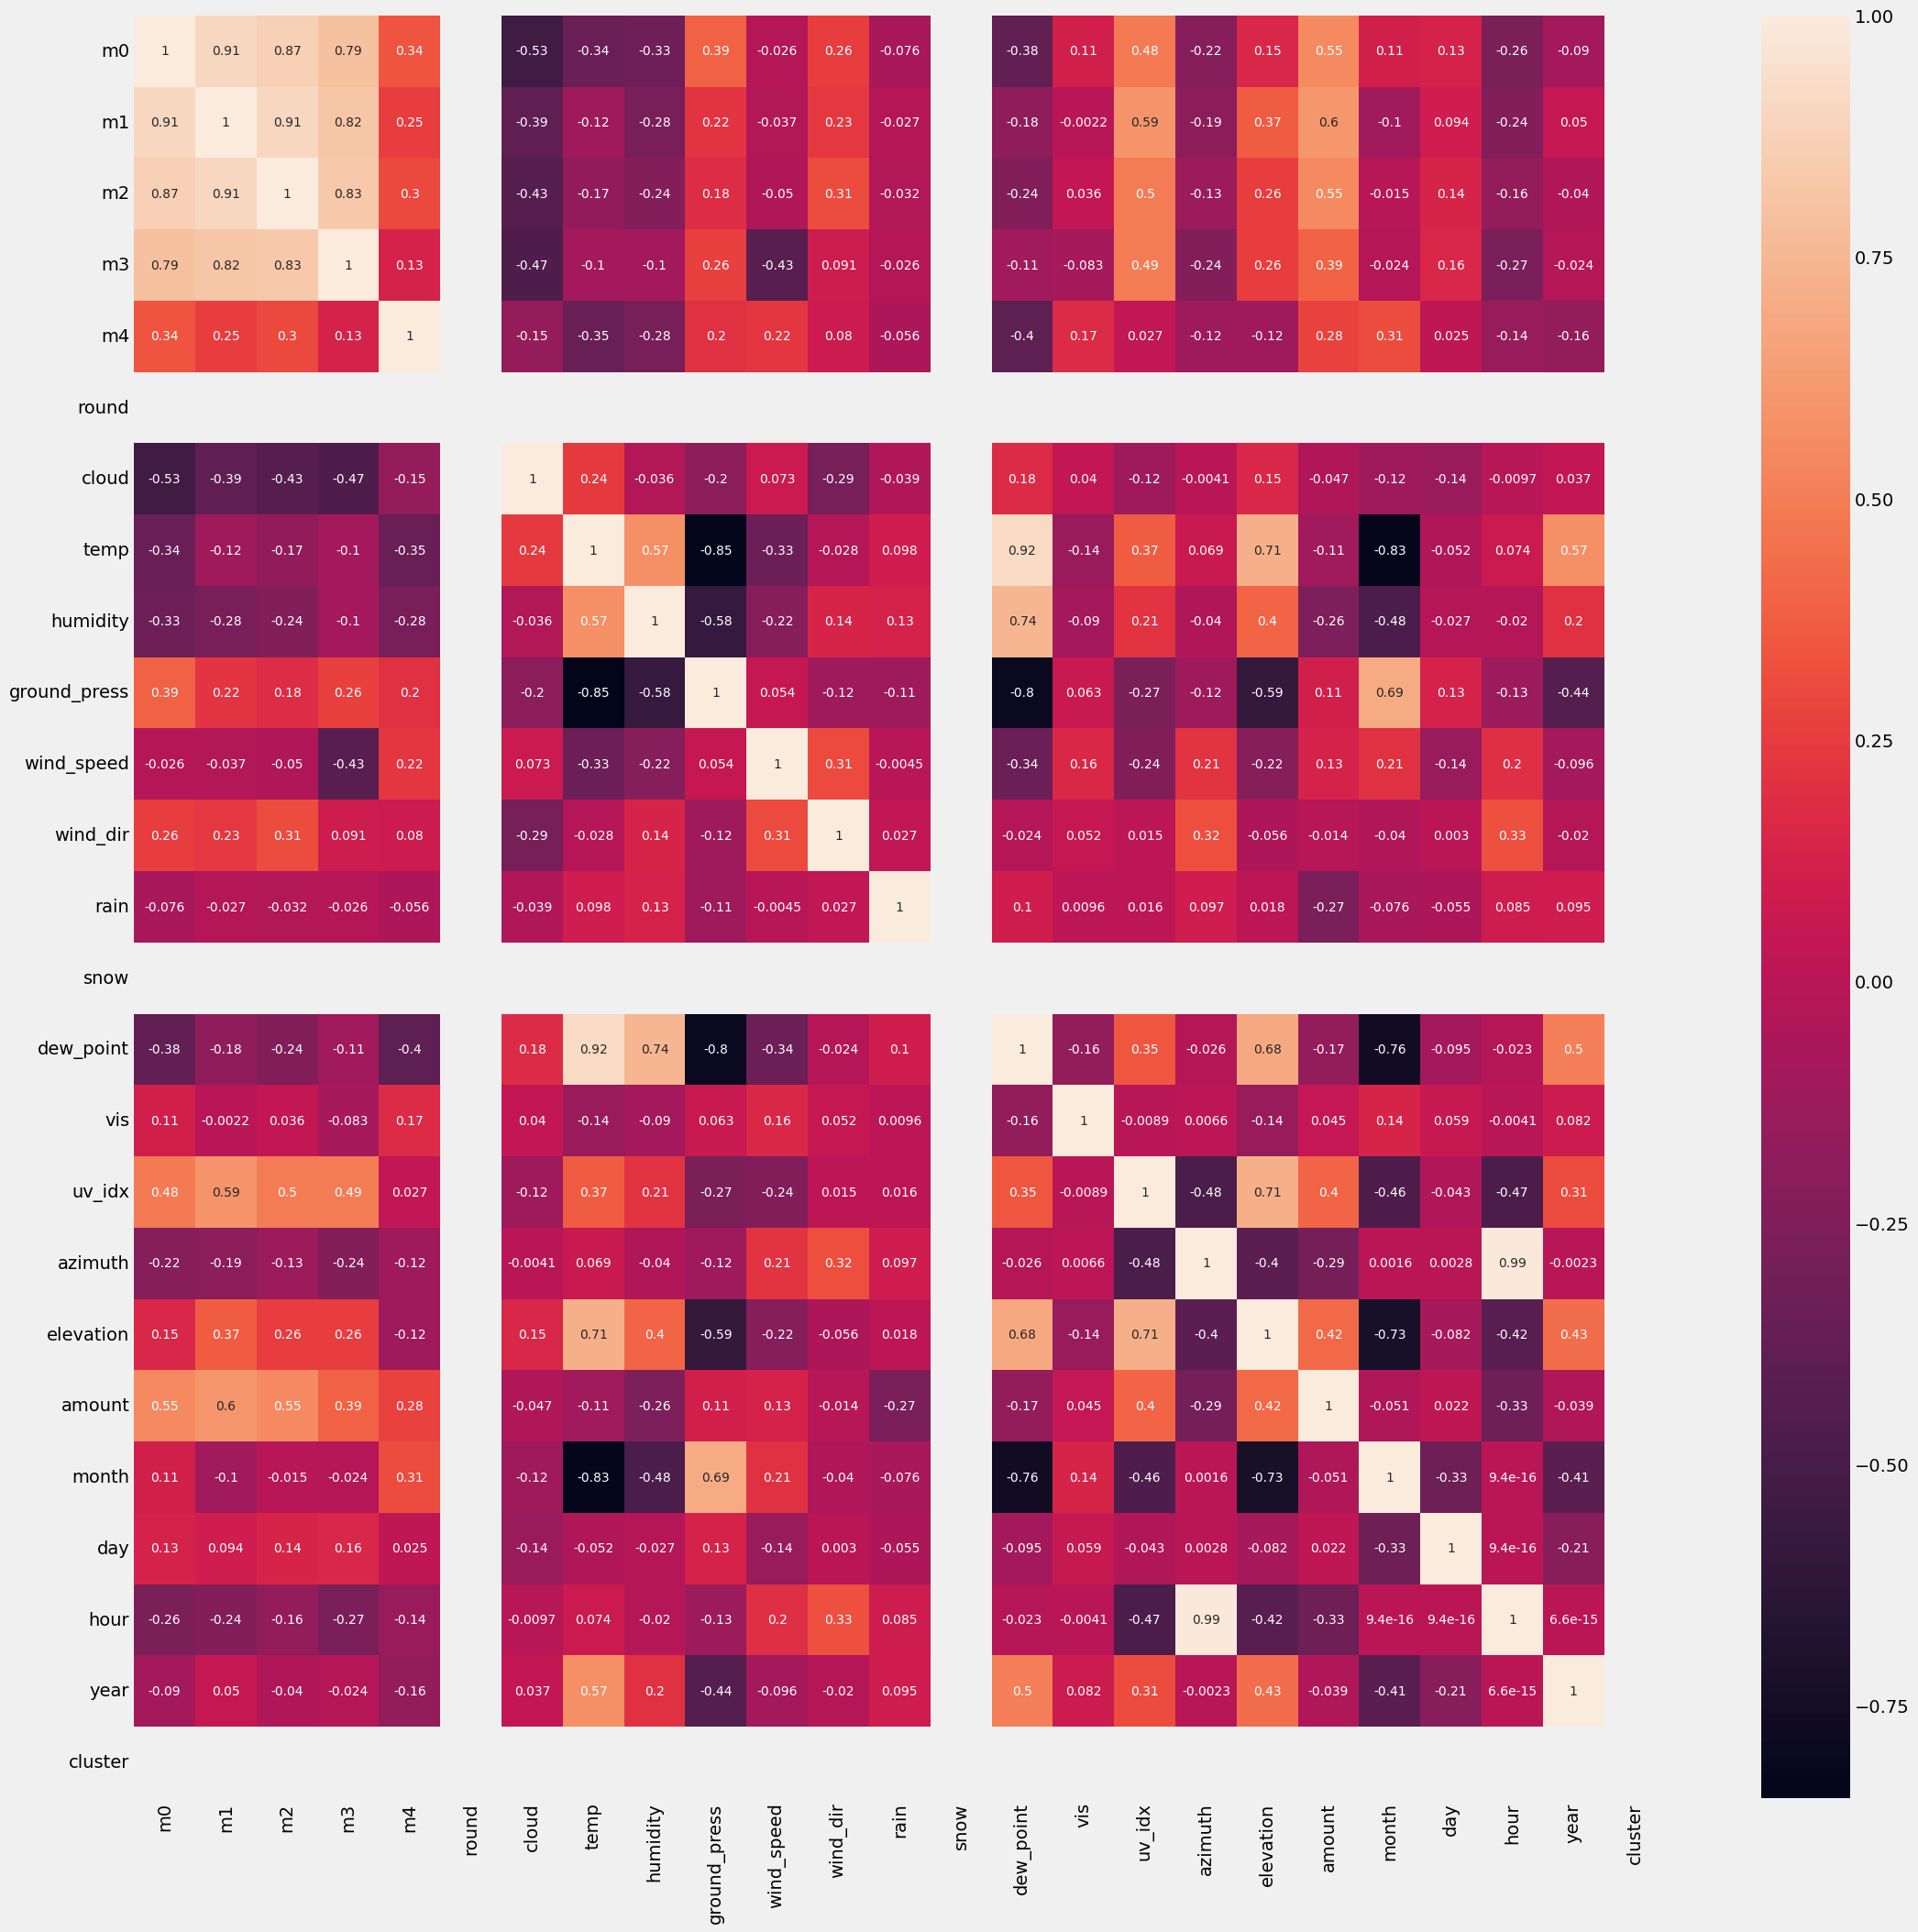

In [31]:
plt.figure(figsize=(24,24))
sns.heatmap(ts_ary.query("cluster==1").corr(),annot=True, annot_kws={"size": 10})

### 클러스터 별로 모델 분리

In [18]:
ts_ary

,m0,m1,m2,m3,m4,time,round,cloud,temp,humidity,...,vis,uv_idx,azimuth,elevation,amount,month,day,hour,year,cluster
1786,52.1409,52.3106,55.2198,52.0965,45.8437,2022-09-01 11:00:00+09:00,1,100.0,24.32,74.0,...,16.0934,7.0,135.254,55.8898,36.0,9,1,11,2022,2
1787,51.8298,53.6636,61.3145,48.4306,40.6616,2022-09-01 12:00:00+09:00,1,100.0,25.02,71.0,...,16.0934,8.0,161.559,62.4236,34.0,9,1,12,2022,2
1788,60.7819,72.4139,74.5632,70.9034,53.2792,2022-09-01 13:00:00+09:00,1,100.0,25.58,70.0,...,16.0934,6.0,194.207,62.8751,22.0,9,1,13,2022,2
1789,59.6068,69.6676,73.3340,65.7185,33.1650,2022-09-01 14:00:00+09:00,1,100.0,25.96,68.0,...,16.0934,5.0,221.728,56.9884,15.0,9,1,14,2022,2
1790,58.0700,61.6508,65.0286,58.8161,19.0536,2022-09-01 15:00:00+09:00,1,99.0,25.97,70.0,...,16.0934,4.0,240.326,47.3516,18.0,9,1,15,2022,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11578,57.8762,59.3476,52.5556,55.5518,51.8007,2023-10-15 11:00:00+09:00,1,12.0,18.98,68.0,...,16.0934,4.0,152.542,42.9224,54.0,10,15,11,2023,0
11579,60.4846,63.2077,52.5277,58.5800,57.0589,2023-10-15 12:00:00+09:00,1,10.0,19.20,67.0,...,16.0934,4.0,172.860,46.6011,51.0,10,15,12,2023,0
11580,61.0122,66.6243,52.7246,64.0328,63.2603,2023-10-15 13:00:00+09:00,1,8.0,19.37,67.0,...,16.0934,4.0,194.339,45.8045,82.0,10,15,13,2023,0
11581,62.4748,63.3071,49.9163,63.1707,56.2874,2023-10-15 14:00:00+09:00,1,10.0,19.47,68.0,...,16.0934,3.0,213.572,40.7522,45.0,10,15,14,2023,0


In [25]:
# 1차 모델링에서 사용할 X데이터셋 생성
# 데이터프레임 이름 읽는 법.
# 변수_몇차모델링_시간분리
# 시간 분리는 (1. 7-10 / 2. 11-14 / 3. 15-19)
# ex) x_df1_1 (x데이터셋, 1차 모델링, 7-10)
x_df1_1 = xy_df_1[["m0","m1","m2","m3","uv_idx","elevation"]]
x_df1_21 = ts_ary[ts_ary["cluster"]==1][["m0","m1","m2","m3","uv_idx","elevation"]]
x_df1_22 = ts_ary[ts_ary["cluster"]==2][["m0","m1","m2","m3","uv_idx","elevation"]]
x_df1_23 = ts_ary[ts_ary["cluster"]==3][["m0","m1","m2","m3","uv_idx","elevation"]]
x_df1_24 = ts_ary[ts_ary["cluster"]==4][["m0","m1","m2","m3","uv_idx","elevation"]]
x_df1_20 = ts_ary[ts_ary["cluster"]==0][["m0","m1","m2","m3","uv_idx","elevation"]]
x_df1_3 = xy_df_3[["m0","m1","m2","m3","uv_idx","elevation"]]
x_df2_1 = xy_df_1.drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour"],axis=1)
x_df2_21 = ts_ary[ts_ary["cluster"]==1].drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour","cluster","year"],axis=1)
x_df2_22 = ts_ary[ts_ary["cluster"]==2].drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour","cluster","year"],axis=1)
x_df2_23 = ts_ary[ts_ary["cluster"]==3].drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour","cluster","year"],axis=1)
x_df2_24 = ts_ary[ts_ary["cluster"]==4].drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour","cluster","year"],axis=1)
x_df2_20 = ts_ary[ts_ary["cluster"]==0].drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour","cluster","year"],axis=1)
x_df2_3 = xy_df_3.drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour"],axis=1)

In [26]:
# 1차 모델링에서 사용할 Y데이터셋 생성
# 표기 법은 X와 동일
# 다만 2차 모델링에서 사용할 Y는 1차 모델링에서 구한 Y_hat을 실제 Y에서 뺀 e임으로 추후에 구해야함
# e = Y - Y_hat
y_df1_1 = xy_df_1["amount"]
y_df1_21 = ts_ary[ts_ary["cluster"]==1]["amount"]
y_df1_22 = ts_ary[ts_ary["cluster"]==2]["amount"]
y_df1_23 = ts_ary[ts_ary["cluster"]==3]["amount"]
y_df1_24 = ts_ary[ts_ary["cluster"]==4]["amount"]
y_df1_20 = ts_ary[ts_ary["cluster"]==0]["amount"]
y_df1_3 = xy_df_3["amount"]

# 모델링1 선형관계 linear or mlp (모델은 바뀔수 있음)

In [21]:
from sklearn.linear_model import LinearRegression

In [24]:
# 1차 모델링 (변수 모델예측량 + 고도 + 자외선 지수)
lm0 = LinearRegression()
lm0.fit(x_df1_20, y_df1_20)
lm1 = LinearRegression()
lm1.fit(x_df1_21, y_df1_21)
lm2 = LinearRegression()
lm2.fit(x_df1_22, y_df1_22)
lm3 = LinearRegression()
lm3.fit(x_df1_23, y_df1_23)
lm4 = LinearRegression()
lm4.fit(x_df1_24, y_df1_24)


LinearRegression()

In [34]:
import joblib
joblib.dump(lm4,"../model/유클리디안클러스터링회귀24_r1.pkl")

['../model/유클리디안클러스터링회귀24_r1.pkl']

## 2차 모델링에 사용할 y값을 만들어야함.
## 2차 모델링에서 사용할 y는 Y-Y_hat = e 임.

In [25]:
# 2차 모델링에 사용할 Y 데이터 셋 생성
y_df2_20 = y_df1_20-lm0.predict(x_df1_20)
y_df2_21 = y_df1_21-lm1.predict(x_df1_21)
y_df2_22 = y_df1_22-lm2.predict(x_df1_22)
y_df2_23 = y_df1_23-lm3.predict(x_df1_23)
y_df2_24 = y_df1_24-lm4.predict(x_df1_24)

# 모델링2 잔차에 대하여 fitting (target variable Y = y_df2_1, y_df2_2, y_df2_3)

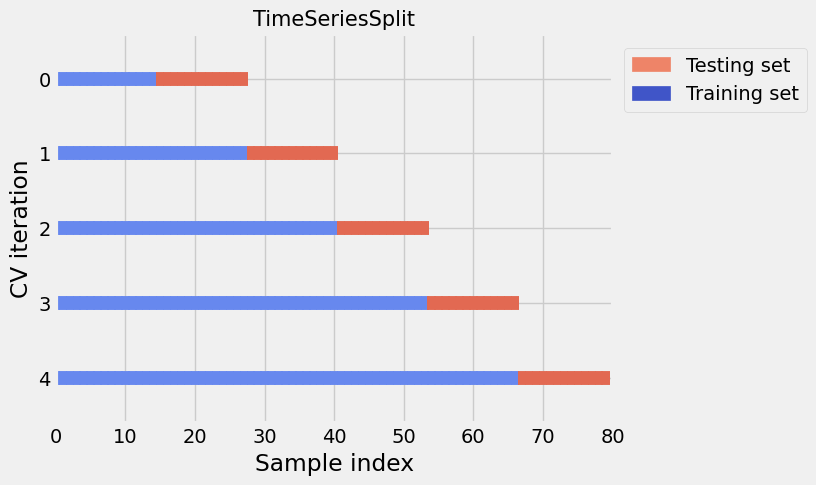

In [26]:
# 1. TimeSeriesSplit 기본
n_split = 5

tscv = TimeSeriesSplit(n_splits=n_split)

plot_cv_indices(tscv, x_df2_20, n_splits=n_split)

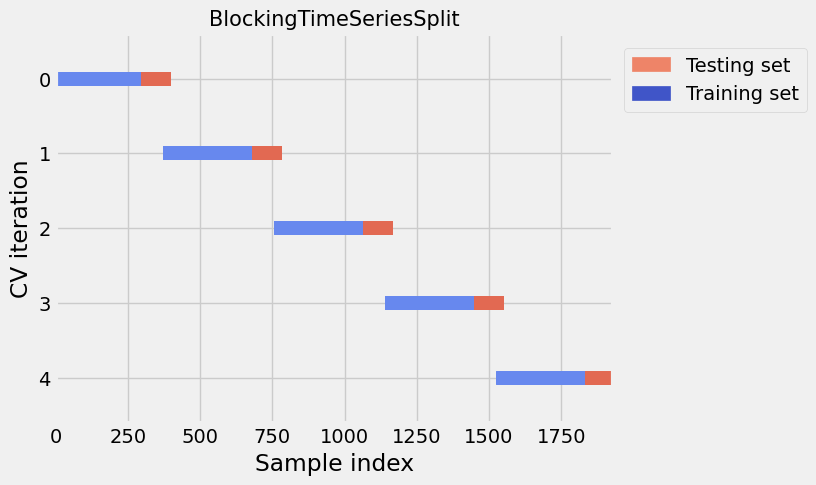

In [23]:
# 2. Blocked TimeSeriesSplit
btscv = BlockingTimeSeriesSplit(n_splits=n_split)
plot_cv_indices(btscv, x_df2_1, n_splits=n_split)

In [29]:
x_df2_20

,cloud,temp,humidity,ground_press,wind_speed,wind_dir,rain,snow,dew_point,vis,azimuth,month,day,year
1858,100.0,24.15,90.0,1009.0,6.83,116.0,0.0,0.0,23.3333,16.09340,136.716,9,4,2022
1859,100.0,24.47,88.0,1008.0,6.39,121.0,0.0,0.0,23.3333,8.04672,162.646,9,4,2022
1860,100.0,24.55,88.0,1008.0,6.82,122.0,0.0,0.0,23.3333,16.09340,194.233,9,4,2022
1861,100.0,25.15,85.0,1008.0,6.06,125.0,0.0,0.0,24.4444,16.09340,221.005,9,4,2022
1862,100.0,26.35,76.0,1007.0,7.67,136.0,0.0,0.0,23.8889,6.43738,239.420,9,4,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11578,12.0,18.98,68.0,1013.0,6.49,319.0,0.0,0.0,12.7778,16.09340,152.542,10,15,2023
11579,10.0,19.20,67.0,1013.0,6.90,313.0,0.0,0.0,12.7778,16.09340,172.860,10,15,2023
11580,8.0,19.37,67.0,1013.0,7.41,309.0,0.0,0.0,13.3333,16.09340,194.339,10,15,2023
11581,10.0,19.47,68.0,1012.0,7.84,309.0,0.0,0.0,13.3333,16.09340,213.572,10,15,2023


In [22]:
## optuna 트리모델 설정

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }

    scores = []
    for i, (train_index, test_index) in enumerate(tscv.split(x_df2_24)):
        x_train, y_train=x_df2_24.iloc[train_index], y_df2_24.iloc[train_index]
        x_test, y_test=x_df2_24.iloc[test_index], y_df2_24.iloc[test_index]

        lgbm_model=LGBMRegressor(**params, boost_from_average=False,
                                  random_state=42)
        lgbm_model.fit(x_train, y_train)

        y_pred=lgbm_model.predict(x_test)
        score = mean_squared_error(y_test,y_pred)


    return score

In [54]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2023-11-06 13:11:24,505] A new study created in memory with name: no-name-6d62187e-48e2-4dce-8cc0-6e1b2bd7627c
[I 2023-11-06 13:11:25,053] Trial 0 finished with value: 85.27770270207171 and parameters: {'n_estimators': 1750, 'max_depth': 3, 'learning_rate': 0.32508363404078455, 'num_leaves': 21, 'min_child_samples': 8, 'reg_alpha': 0.8251644606867423, 'reg_lambda': 0.005431672281678834}. Best is trial 0 with value: 85.27770270207171.
[I 2023-11-06 13:11:25,259] Trial 1 finished with value: 88.67888637392478 and parameters: {'n_estimators': 1927, 'max_depth': 15, 'learning_rate': 0.17051178051838486, 'num_leaves': 8, 'min_child_samples': 83, 'reg_alpha': 0.5281647303628478, 'reg_lambda': 0.6775262070764609}. Best is trial 0 with value: 85.27770270207171.
[I 2023-11-06 13:11:25,508] Trial 2 finished with value: 78.0309963181494 and parameters: {'n_estimators': 587, 'max_depth': 3, 'learning_rate': 0.28063254626595746, 'num_leaves': 5, 'min_child_samples': 10, 'reg_alpha': 0.9696583207

In [55]:
print(study.best_value)
print(study.best_params)

64.64899739836105
{'n_estimators': 1865, 'max_depth': 3, 'learning_rate': 0.218752152533657, 'num_leaves': 19, 'min_child_samples': 5, 'reg_alpha': 0.7448851107187883, 'reg_lambda': 0.10259407851145408}


# 모델 학습 후 저장

In [35]:
import joblib

In [56]:
# 모델 학습 후 저장 !!! 필 히  이름 바 꿀 것!!!!!!11
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x_df2_24,y_df2_24)
joblib.dump(model,"../model/유클리디안클러스터링잔차24_r1.pkl")

['../model/유클리디안클러스터링잔차24_r1.pkl']

# 예측 시작

## 예측하려는 파일을 이제 시간대별 round별로 나눠야함 
## 해당 기능을 수행하는 함수 선언

In [19]:
ts_ary

,m0,m1,m2,m3,m4,time,round,cloud,temp,humidity,...,vis,uv_idx,azimuth,elevation,amount,month,day,hour,year,cluster
1786,52.1409,52.3106,55.2198,52.0965,45.8437,2022-09-01 11:00:00+09:00,1,100.0,24.32,74.0,...,16.0934,7.0,135.254,55.8898,36.0,9,1,11,2022,2
1787,51.8298,53.6636,61.3145,48.4306,40.6616,2022-09-01 12:00:00+09:00,1,100.0,25.02,71.0,...,16.0934,8.0,161.559,62.4236,34.0,9,1,12,2022,2
1788,60.7819,72.4139,74.5632,70.9034,53.2792,2022-09-01 13:00:00+09:00,1,100.0,25.58,70.0,...,16.0934,6.0,194.207,62.8751,22.0,9,1,13,2022,2
1789,59.6068,69.6676,73.3340,65.7185,33.1650,2022-09-01 14:00:00+09:00,1,100.0,25.96,68.0,...,16.0934,5.0,221.728,56.9884,15.0,9,1,14,2022,2
1790,58.0700,61.6508,65.0286,58.8161,19.0536,2022-09-01 15:00:00+09:00,1,99.0,25.97,70.0,...,16.0934,4.0,240.326,47.3516,18.0,9,1,15,2022,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11578,57.8762,59.3476,52.5556,55.5518,51.8007,2023-10-15 11:00:00+09:00,1,12.0,18.98,68.0,...,16.0934,4.0,152.542,42.9224,54.0,10,15,11,2023,0
11579,60.4846,63.2077,52.5277,58.5800,57.0589,2023-10-15 12:00:00+09:00,1,10.0,19.20,67.0,...,16.0934,4.0,172.860,46.6011,51.0,10,15,12,2023,0
11580,61.0122,66.6243,52.7246,64.0328,63.2603,2023-10-15 13:00:00+09:00,1,8.0,19.37,67.0,...,16.0934,4.0,194.339,45.8045,82.0,10,15,13,2023,0
11581,62.4748,63.3071,49.9163,63.1707,56.2874,2023-10-15 14:00:00+09:00,1,10.0,19.47,68.0,...,16.0934,3.0,213.572,40.7522,45.0,10,15,14,2023,0


<AxesSubplot: >

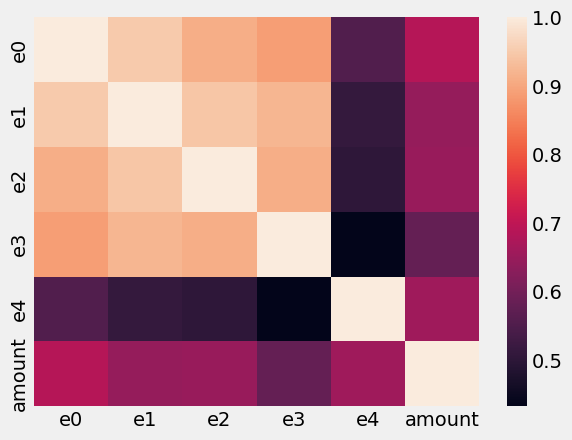

In [27]:
ts_ary["e0"] = ts_ary["amount"]-ts_ary["m0"]
ts_ary["e1"] = ts_ary["amount"]-ts_ary["m1"]
ts_ary["e2"] = ts_ary["amount"]-ts_ary["m2"]
ts_ary["e3"] = ts_ary["amount"]-ts_ary["m3"]
ts_ary["e4"] = ts_ary["amount"]-ts_ary["m4"]
sns.heatmap(ts_ary[["e0","e1","e2","e3","e4","amount"]].corr())

In [22]:
c0 = ts_ary[ts_ary["cluster"]==0][["e0","e1","e2","e3","e4","amount"]]
c1 = ts_ary[ts_ary["cluster"]==1][["e0","e1","e2","e3","e4","amount"]]
c2 = ts_ary[ts_ary["cluster"]==2][["e0","e1","e2","e3","e4","amount"]]
c3 = ts_ary[ts_ary["cluster"]==3][["e0","e1","e2","e3","e4","amount"]]
c4 = ts_ary[ts_ary["cluster"]==4][["e0","e1","e2","e3","e4","amount"]]


<AxesSubplot: >

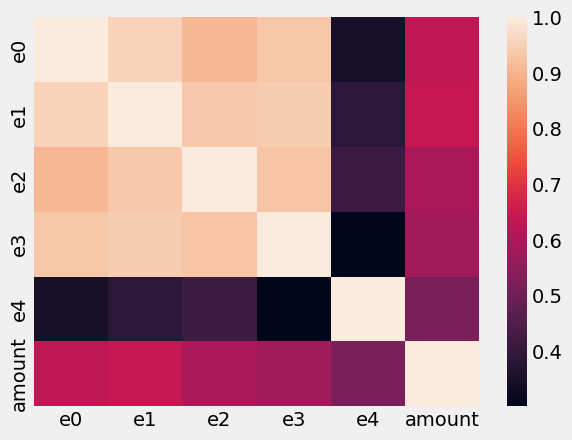

In [42]:
sns.heatmap(c0.corr())

### 클러스터 분류 모델 생성

In [28]:
from scipy import stats

In [29]:
ts_ary["round"].nunique()

1

In [30]:
clf_ary = ts_ary.drop(["m0","m1","m2","m3","m4","time","round","hour","year","cluster","e0","e1","e2","e3","e4"],axis=1)
X = clf_ary.drop(["amount"],axis=1)
Y = ts_ary["cluster"]

In [31]:
X.columns

Index(['cloud', 'temp', 'humidity', 'ground_press', 'wind_speed', 'wind_dir',
       'rain', 'snow', 'dew_point', 'vis', 'uv_idx', 'azimuth', 'elevation',
       'month', 'day'],
      dtype='object')

In [32]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics  import accuracy_score

In [28]:
kf = KFold(n_splits=5)

In [37]:
## optuna 트리모델 설정

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
        'max_depth': trial.suggest_int('max_depth', 1, 10, step=1, log=False), 
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True), 
        'n_estimators': trial.suggest_int('n_estimators', 8, 1024, step=1, log=True), 
        'objective': 'multiclass', 
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=1, log=False), 
        'subsample': trial.suggest_float('subsample', 0.7, 1.0), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 42
    }
    

    scores = []
    
    for train_index, test_index in kf.split(X):
        x_train, y_train=X.iloc[train_index], Y.iloc[train_index]
        x_test, y_test=X.iloc[test_index], Y.iloc[test_index]

        lgbm_model=LGBMClassifier(**params)
        lgbm_model.fit(x_train, y_train)

        y_pred=lgbm_model.predict(x_test)
        score = accuracy_score(y_test,y_pred)
        
    
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-11-06 22:42:03,134] A new study created in memory with name: no-name-f60c49b5-78f6-4cba-88a1-3dcebef60956
[I 2023-11-06 22:42:08,388] Trial 0 finished with value: 0.47794117647058826 and parameters: {'num_leaves': 23, 'max_depth': 8, 'learning_rate': 0.006089714329544737, 'n_estimators': 808, 'class_weight': 'balanced', 'min_child_samples': 37, 'subsample': 0.882770945157509, 'colsample_bytree': 0.7274924166266935, 'reg_alpha': 0.5938386278516399, 'reg_lambda': 3.465001692871671}. Best is trial 0 with value: 0.47794117647058826.
[I 2023-11-06 22:42:10,630] Trial 1 finished with value: 0.3897058823529412 and parameters: {'num_leaves': 123, 'max_depth': 4, 'learning_rate': 0.08423899831574483, 'n_estimators': 761, 'class_weight': 'balanced', 'min_child_samples': 21, 'subsample': 0.8872940979754267, 'colsample_bytree': 0.7638815518449023, 'reg_alpha': 0.22898755823325279, 'reg_lambda': 0.7572278688520084}. Best is trial 0 with value: 0.47794117647058826.
[I 2023-11-06 22:42:11,544

KeyboardInterrupt: 

In [108]:
print(study.best_value)
print(study.best_params)

0.5735294117647058
{'num_leaves': 100, 'max_depth': 4, 'learning_rate': 0.014104059996241102, 'n_estimators': 427, 'class_weight': None, 'min_child_samples': 37, 'subsample': 0.7466070464516096, 'colsample_bytree': 0.9225539653991622, 'reg_alpha': 0.18226810163564938, 'reg_lambda': 5.420816486234735}


In [37]:

model=LGBMClassifier(num_leaves= 100, max_depth= 4, learning_rate= 0.014104059996241102, n_estimators= 427, min_child_samples= 37, subsample= 0.7466070464516096, colsample_bytree= 0.9225539653991622, reg_alpha= 0.18226810163564938, reg_lambda= 5.420816486234735 ,random_state=42)
model.fit(X,Y)

LGBMClassifier(colsample_bytree=0.9225539653991622,
               learning_rate=0.014104059996241102, max_depth=4,
               min_child_samples=37, n_estimators=427, num_leaves=100,
               random_state=42, reg_alpha=0.18226810163564938,
               reg_lambda=5.420816486234735, subsample=0.7466070464516096)

In [34]:
a = pd.read_csv("../data/weather_forecasts/wf10_2023-10-29.csv")

In [35]:
a["time"] = pd.to_datetime(a["time"])
a["month"] = a["time"].dt.month
a["day"] = a["time"].dt.day
a["hour"] = a["time"].dt.hour
a = a[(a["hour"]>=11) & (a["hour"]<=15)]
a.drop(["time","hour"],axis=1,inplace=True)

In [38]:
model.predict_proba(a)

array([[0.01467894, 0.88262055, 0.01271192, 0.08509111, 0.00489748],
       [0.01637839, 0.87075543, 0.00466497, 0.10247298, 0.00572824],
       [0.01267935, 0.88095834, 0.00374217, 0.09759316, 0.00502698],
       [0.03794546, 0.84051004, 0.00447767, 0.10893103, 0.0081358 ],
       [0.03177482, 0.85304922, 0.00574025, 0.07866751, 0.0307682 ]])

In [39]:
## test data set 만드는 함수
def make_test_xy(wf,gf):
    gf.columns = ["time","m0","m1","m2","m3","m4"]
    train = pd.merge(gf,wf,on="time")
    train["time"] = pd.to_datetime(train["time"])
    train["month"]=train["time"].dt.month
    train["day"]=train["time"].dt.day
    train["hour"]=train["time"].dt.hour
    
    train_1 = train[(train["hour"]<=10) & (train["hour"]>=7)]
    train_2 = train[(train["hour"]<=15) & (train["hour"]>=11)]
    train_3 = train[(train["hour"]<=19) & (train["hour"]>=15)]
    
    train11 = train_1[["m0","m1","m2","m3","uv_idx","elevation"]]
    train12 = train_2[["m0","m1","m2","m3","uv_idx","elevation"]]
    train13 = train_3[["m0","m1","m2","m3","uv_idx","elevation"]]
    train21 = train_1.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour"],axis=1)
    train22 = train_2.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour"],axis=1)
    train23 = train_3.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour"],axis=1)
    
    return train11,train12,train13,train21,train22,train23

In [40]:
# 예측에 사용할 데이터 셋 불러오기 
x_pred_ori = pd.read_csv("../data/gen_fcst_10_2023-10-29.csv")
x_pred_wf = pd.read_csv("../data/weather_forecasts/wf10_2023-10-29.csv")

In [41]:
# 함수에 넣어서 데이터셋 분리
test11,test12,test13,test21,test22,test23 = make_test_xy(x_pred_wf,x_pred_ori)

In [42]:
import joblib

In [43]:
model10=joblib.load("../model/유클리디안클러스터링회귀20_r1.pkl")
model11=joblib.load("../model/유클리디안클러스터링회귀21_r1.pkl")
model12=joblib.load("../model/유클리디안클러스터링회귀22_r1.pkl")
model13=joblib.load("../model/유클리디안클러스터링회귀23_r1.pkl")
model14=joblib.load("../model/유클리디안클러스터링회귀24_r1.pkl")


In [ ]:
유클리디안클러스터링잔차24_r1

In [44]:
# 예측 진행 (1차 모델링 y_hat)
y_pred10=model10.predict(test12)
y_pred11=model11.predict(test12)
y_pred12=model12.predict(test12)
y_pred13=model13.predict(test12)
y_pred14=model14.predict(test12)

In [45]:
model20=joblib.load("../model/유클리디안클러스터링잔차20_r1.pkl")
model21=joblib.load("../model/유클리디안클러스터링잔차21_r1.pkl")
model22=joblib.load("../model/유클리디안클러스터링잔차22_r1.pkl")
model23=joblib.load("../model/유클리디안클러스터링잔차23_r1.pkl")
model24=joblib.load("../model/유클리디안클러스터링잔차24_r1.pkl")

In [46]:
# 예측 진행 (2차 모델링 )
y_pred20=model20.predict(test22)
y_pred21=model21.predict(test22)
y_pred22=model22.predict(test22)
y_pred23=model23.predict(test22)
y_pred24=model24.predict(test22)

In [47]:
result0 = y_pred10+y_pred20
result1 = y_pred11+y_pred21
result2 = y_pred12+y_pred22
result3 = y_pred13+y_pred23
result4 = y_pred14+y_pred24

In [48]:
prob = model.predict_proba(a)
final_mat = [result0,result1,result2,result3,result4]
res = np.dot(prob,final_mat)
ans = np.diagonal(res)

In [49]:
real_dict = {"1025" : [0, 0, 0, 0, 0, 0,
                      0, 10, 31, 54, 70, 72, 78, 73, 63, 40, 20, 3, 0,
                      0, 0, 0, 0, 0],
             "1026" : [0, 0, 0, 0, 0, 0,
                      1, 3, 11, 40, 61, 52, 75, 61, 62, 40, 18, 2, 0,
                      0, 0, 0, 0, 0],
             "1027" : [0, 0, 0, 0, 0, 0,
                      1, 9, 36, 46, 53, 74, 89, 81, 64, 54, 23, 4, 0,
                      0, 0, 0, 0, 0],
             "1028" : [0, 0, 0, 0, 0, 0,
                      0, 5, 29, 56, 67, 82, 78, 72, 63, 46, 17, 3, 0,
                      0, 0, 0, 0, 0],
             "1029" : [0, 0, 0, 0, 0, 0,
                      0, 4, 20, 56, 66, 76, 53, 57, 66, 42, 20, 2, 0,
                      0, 0, 0, 0, 0],
             "1030" : [0, 0, 0, 0, 0, 0,
                      0, 4, 20, 56, 65, 79, 81, 75, 62, 45, 22, 3, 0,
                      0, 0, 0, 0, 0],
             "1031" : [0, 0, 0, 0, 0, 0,
                      0, 4, 8, 22, 37, 76, 73, 75, 58, 44, 22, 4, 0,
                      0, 0, 0, 0, 0],
             "1101" : [0, 0, 0, 0, 0, 0,
                       0, 6, 30, 51, 58, 68, 68, 69, 55, 38, 18, 1, 0,
                       0, 0, 0, 0, 0],
             "1102" : [0, 0, 0, 0, 0, 0,
                       0, 4, 32, 46, 71, 76, 79, 73, 64, 44, 22, 4, 0,
                       0, 0, 0, 0, 0]}

In [50]:
import numpy as np

def testMSEnIncentive(pred,day):
    realGens1030 = np.array(day)    
    
    rss = np.power(pred - realGens1030, 2)
    rss1 = rss[6:10]
    rss2 = rss[10:14]
    rss3 = rss[14:19]
    mse1 = sum(rss1/len(rss1))
    mse2 = sum(rss2/len(rss2))
    mse3 = sum(rss3/len(rss3))
    mse = [mse1,mse2,mse3]

    score_df = abs(pred - realGens1030)*100/99
    score = []
    for idx, i in enumerate(score_df):
        if i <=6:
            score.append(realGens1030[idx] * 4)
        elif (i <=8) & (i > 6):
            score.append(realGens1030[idx] * 3)
        else:
            score.append(0)
    score1 = score[6:10]
    score2 = score[10:14]
    score3 = score[14:19]
    final_score = [score1,score2,score3]
    
    sum_score = sum(score)

    return mse, final_score , score, sum_score

In [51]:
day = real_dict["1029"]
testMSEnIncentive(pred,day)

NameError: name 'pred' is not defined

In [52]:
list(ans)

[66.56410479133015,
 73.06685507670038,
 74.3308240520159,
 69.34023460641076,
 57.36388533028355]

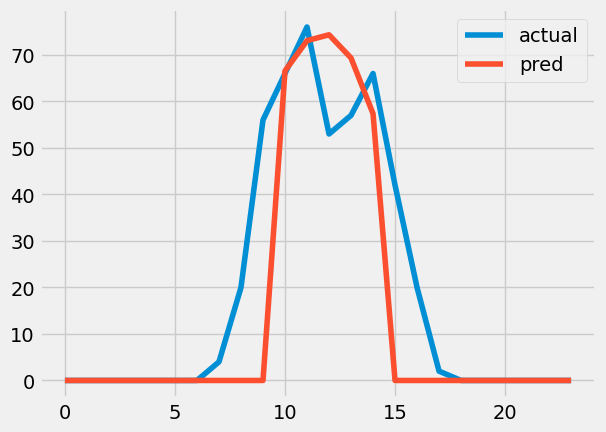

In [54]:
def make_gen_plot(actual,pred):
    pred = [0,0,0,0,0,0]+[0,0,0,0]+pred+[0,0,0,0]+[0,0,0,0,0]
    plt.figure()
    sns.lineplot(actual,label="actual")
    sns.lineplot(pred,label="pred")
    plt.legend()

# 사용법 예시
# pred그냥 예측 나온 13개만 넣으면됩니다.
# actual에 real_dict는 어제 만든겁니다. 인지좀 
actual = real_dict["1029"]
pred = list(ans)

make_gen_plot(actual,pred)

In [3]:

for i in model.feature_importabces_:
    print(i, end="\n")

1
2
3
4
